In [72]:
import os
import subprocess

columns_name = ['Flags', 'IntendedVsync', 'Vsync', 'OldestInputEvent', 'NewestInputEvent', 
                     'HandleInputStart', 'AnimationStart', 'PerformTraversalsStart', 'DrawStart', 
                     'SyncQueued', 'SyncStart', 'IssueDrawCommandsStart', 'SwapBuffers', 'FrameCompleted']

columns2_name = ['Vsync', 'Handle Input', 'Animation', 'Perform Traversals', 'Draw', 
                       'Sync', 'Issue Draw Commands']

subprocess.call("adb shell dumpsys gfxinfo mobisocial.arcade reset", shell = True)
subprocess.call("adb shell input swipe 700 1500 700 200 5000", shell = True)

# data = os.popen("adb shell dumpsys gfxinfo mobisocial.arcade framestats | grep -A 1000 'PROFILEDATA'").read().splitlines()
data = os.popen("adb shell dumpsys gfxinfo mobisocial.arcade framestats").read().splitlines()

# data
# lista = []

# index = 0
# flag = 0
# for x in data:
#     if flag != 2:
#         if x == '---PROFILEDATA---':
#             flag += 1
#             print ('Ya')
#         lista.append(data[index])
#     index += 1
# lista



# lista = []

# index = 0
# flag = 0
# for x in data: 
#     if flag > 0 and flag < 2:
#         lista.append(data[index])
    
#     if x == '---PROFILEDATA---':
#         flag += 1
    
#     if flag == 2:
#         lista.pop()
    
#     index += 1
# lista

def clip_data(data):
    output = []
    index = 0
    flag = 0
    
    for x in data:
        if flag > 0 and flag < 2:
            output.append(data[index])
        if x == '---PROFILEDATA---':
            flag += 1    
        if flag == 2:
            output.pop() 
        index += 1
    
    # 移除標頭
    output.pop(0)
    return output


data = clip_data(data)
data

['0,959454881973817,959454898521889,959454866000000,959454874000000,959454901780779,959454903819703,959454904160626,959454907013318,959454907867472,959454908387549,959454909283857,959454918175319,959454923841243,',
 '0,959454915240711,959454915240711,9223372036854775807,0,959454915944319,959454915977858,959454916375550,959454952098015,959454962272324,959454962433016,959454963983478,959454971334556,959454974194248,',
 '0,959454931874158,959454948422230,9223372036854775807,0,959454964560940,959454964593478,959454965808017,959454967485478,959454968413017,959455000602405,959455001384636,959455003824713,959455008162021,',
 '0,959454965141052,959454998237196,959454991000000,959454993237196,959455003100020,959455007522098,959455007903944,959455018827406,959455019049791,959455019144022,959455021053253,959455029669100,959455034556870,',
 '0,959455047771351,959455047771351,959455042000000,959455042771351,959455051022333,959455055773641,959455056039795,959455060322103,959455060766795,959455068859

In [84]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import os
import time

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.style.use('ggplot')

print('start')

# 待測 App
# package_name = "mobisocial.arcade"
package_name = "com.instagram.android"
# package_name = "com.google.android.youtube"

# 執行次數
execute_count = 1

# 滑動次數（換頁）
swipe_count = 1

# 滑動秒數（ms）
swipe_speed = "500"

# adb 指令
reset_command = "adb shell dumpsys gfxinfo " + package_name +" reset"
swipe_command = "adb shell input swipe 700 1500 700 200 " + swipe_speed
dumpsys_command = "adb shell dumpsys gfxinfo " + package_name +" framestats"

# function declaration
def clip_data(data):
    output = []
    index = 0
    flag = 0
    
    for x in data:
        if flag > 0 and flag < 2:
            output.append(data[index])
        if x == '---PROFILEDATA---':
            flag += 1    
        if flag == 2:
            output.pop() 
        index += 1
    
    # 移除標頭
    output.pop(0)
    return output

info_columns_name = ['Flags', 'IntendedVsync', 'Vsync', 'OldestInputEvent', 'NewestInputEvent', 
                     'HandleInputStart', 'AnimationStart', 'PerformTraversalsStart', 'DrawStart', 
                     'SyncQueued', 'SyncStart', 'IssueDrawCommandsStart', 'SwapBuffers', 'FrameCompleted']

output_columns_name = ['Vsync', 'Handle Input', 'Animation', 'Perform Traversals', 'Draw', 
                       'Sync', 'Issue Draw Commands']

info_df = pd.DataFrame(columns = info_columns_name)
output_df = pd.DataFrame(columns = output_columns_name)

i = 0
for j in range(1, execute_count + 1):
    print("開始執行第 " + str(j) + " 次...")
    
    for k in range(1, swipe_count + 1):
        
        subprocess.call(reset_command, shell = True)
        print("清理前次資料")
        time.sleep(1)
        
        print("執行滑動換頁第 " + str(k) + " 次...")
        subprocess.call(swipe_command, shell = True)
        
        info_data = os.popen(dumpsys_command).read().splitlines()
        #篩選資料
        info_data = clip_data(info_data)

        for line in info_data:
            eachline = line.split(',')
            eachline = list(filter(None, eachline))
            if (len(eachline) == len(info_columns_name)) :
                series = pd.Series(eachline, dtype = "int", index = info_columns_name)
                info_df.loc[i] = series 
                i += 1

output_df['Vsync'] = info_df['Vsync'] - info_df['IntendedVsync']
output_df['Handle Input'] = (info_df['AnimationStart'] - info_df['HandleInputStart'])/1000000
output_df['Animation'] = (info_df['PerformTraversalsStart'] - info_df['AnimationStart'])/1000000
output_df['Perform Traversals'] = (info_df['DrawStart'] - info_df['PerformTraversalsStart'])/1000000
output_df['Draw'] = (info_df['SyncStart'] - info_df['DrawStart'])/1000000
output_df['Sync'] = (info_df['IssueDrawCommandsStart'] - info_df['SyncStart'])/1000000
output_df['Issue Draw Commands'] = (info_df['FrameCompleted'] - info_df['IssueDrawCommandsStart'])/1000000
output_df['TotalTimeSpent'] = (info_df['FrameCompleted'] - info_df['IntendedVsync'])/1000000

# 移除 Vsync 不為 0 的列(?)
# output_df = output_df.drop(output_df[output_df.Vsync > 0].index)

print("end")

count = len(output_df.index)
issue = output_df.loc[output_df.TotalTimeSpent > 16, 'TotalTimeSpent'].count()

print("--------------------")
time.sleep(1)
print("Count: " + str(count))
print("Issue: " + str(issue))
print("Error rate: " + str(issue/count))
print("--------------------")

start
開始執行第 1 次...
清理前次資料
執行滑動換頁第 1 次...
end
--------------------
Count: 25
Issue: 9
Error rate: 0.36
--------------------


繪圖準備...


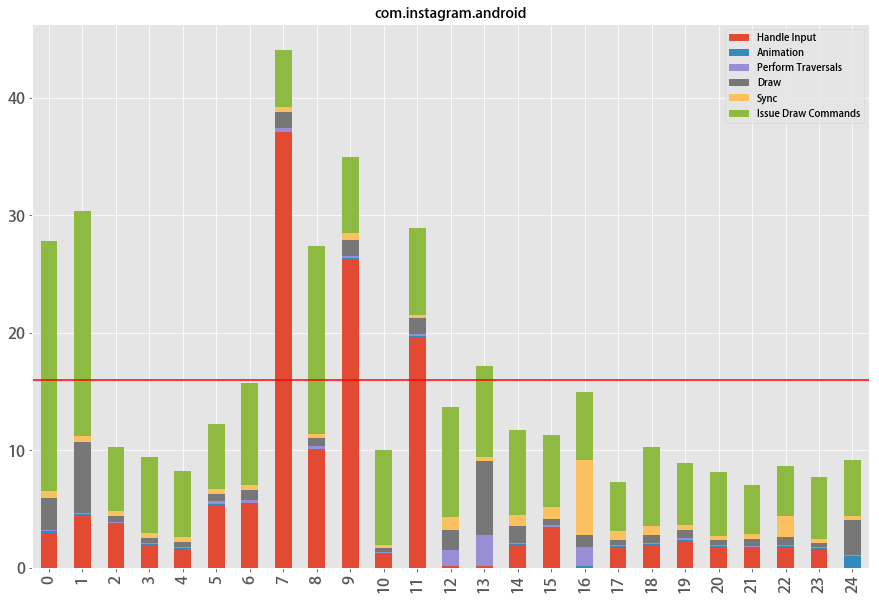

In [85]:
print("繪圖準備...")
output_df.loc[:, 'Handle Input':'Issue Draw Commands'].plot(kind = 'bar', figsize = (15,10), stacked = True, title = package_name, fontsize = 16)
plt.axhline(y = 16, color = 'r')

Count: 25
Issue: 9
Error rate: 0.36
--------------------


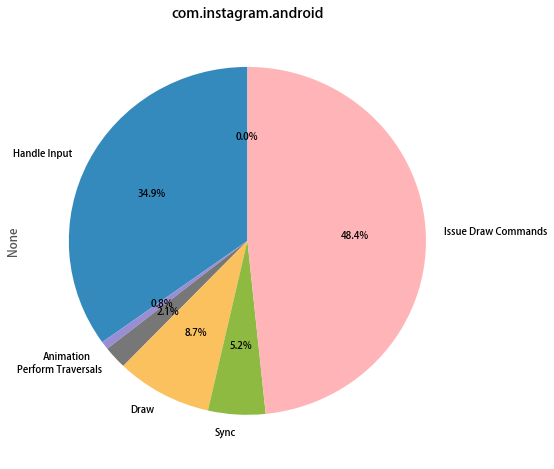

In [86]:
stat_sr_index = ['Vsync', 'Handle Input', 'Animation', 'Perform Traversals', 'Draw', 
                       'Sync', 'Issue Draw Commands']

values = [output_df['Vsync'].mean(), output_df['Handle Input'].mean(), output_df['Animation'].mean(), 
                    output_df['Perform Traversals'].mean(), output_df['Draw'].mean(), output_df['Sync'].mean(),
                    output_df['Issue Draw Commands'].mean()]

stat_sr = pd.Series(values, index = stat_sr_index)

stat_sr.plot(kind = 'pie', figsize = (8,8), startangle = 90, autopct = '%1.1f%%', title = package_name)
# stat_sr

print("Count: " + str(count))
print("Issue: " + str(issue))
print("Error rate: " + str(issue/count))
print("--------------------")


In [ ]:
# stat_columns_name = ['Vsync Mean', 'Handle Input Mean', 'Animation Mean', 'Perform Traversals Mean', 'Draw Mean', 
#                        'Sync Mean', 'Issue Draw Commands Mean']
# stat_df = pd.DataFrame(columns = stat_columns_name)
# stat_df['Vsync Mean'][1] = output_df['Vsync'].mean()
# stat_df['Handle Input Mean'] = output_df['Handle Input'].mean()
# stat_df['Animation Mean'] = output_df['Animation'].mean()
# stat_df['Perform Traversals Mean'] = output_df['Perform Traversals'].mean()
# stat_df['Draw Mean'] = output_df['Draw'].mean()
# stat_df['Sync Mean'] = output_df['Sync'].mean()
# stat_df['Issue Draw Commands Mean'] = output_df['Issue Draw Commands'].mean()

# stat_df.loc[0] = [output_df['Vsync'].mean(), output_df['Handle Input'].mean(), output_df['Animation'].mean(), 
#                   output_df['Perform Traversals'].mean(), output_df['Draw'].mean(), output_df['Sync'].mean(), 
#                   output_df['Issue Draw Commands'].mean()]
# stat_df.plot(kind = 'pie', figsize = (8,8), subplots = False)

# Issue Draw Commands
>The time at which the hardware renderer started issuing drawing commands to the GPU.

### Problems like <font color="blue">too much overdraw or inefficient rendering effects</font> show up here.

# Draw
>This is the start point of recording the display lists of any views that were invalidated.

### How long it took to call <font color="blue">View.draw()</font> on all the invalidated views in the tree.

# Sync
>The time at which the sync phase of the drawing started.

### If the time between this and ISSUE_DRAW_COMMANDS_START is substantial (>0.4ms or so), it typically <font color="blue">indicates a lot of new Bitmaps were drawn </font> which must be uploaded to the GPU.

# Handle Input
>The timestamp at which input events were dispatched to the application.

### If this number is high (>2ms), this indicates the app is spending <font color="blue">an unusually long time processing input events, such as View.onTouchEvent()</font>, which may indicate this work needs to be optimized, or offloaded to a different thread. Note that there are some scenarios, such as click events that launch new activities or similar, where it is expected and acceptable that this number is large.

# Animation
>How long it took to evaluate all the animators (ObjectAnimator, ViewPropertyAnimator, and Transitions being the common ones) that are running.

### If this number is high (>2ms), check to see if your app has written any custom animators or what fields ObjectAnimators are animating and ensure they are appropriate for an animation.

# Perform Traversals
>How long the layout & measure phases took to complete.

### During a scroll, or animation, you would hope this should be close to zero...